In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

import numba
from numba import jit, njit, vectorize, cuda

print("Numba", numba.__version__)

Numba 0.42.0


# Numba [link 1](https://towardsdatascience.com/speed-up-your-algorithms-part-2-numba-293e554c5cc1) [link 2](https://nbviewer.jupyter.org/github/vistalab-technion/cs236605-tutorials/blob/master/tutorial10/tutorial10-cuda.ipynb)

Works well with **numpy**, but not with pandas

## Scenarios
- **Object mode** `@jit`
- **Compile mode** `@jit(nopython=True)`
- **Multithreading** `@jit(nopython=True, parallel=True)`
  - Automatic multithreading of array expressions and reductions
  - Explicit multithreading of loops with `prange()`
  - External multithreading with tools like concurrent.futures or Dask.
- **Vectorization SIMD** `@vectorize`

In [5]:
@jit(nopython=True)
def go_fast(a): # Function is compiled to machine code when called the first time
    trace = 0
    # assuming square input matrix
    for i in range(a.shape[0]):   # Numba likes loops
        trace += np.tanh(a[i, i]) # Numba likes NumPy functions
    return a + trace              # Numba likes NumPy broadcasting

The function has not yet been compiled. To do that, we need to call the function:

If we call it again, it executes without another compilation step.

## benchmark

To benchmark Numba-compiled functions, the %timeit magic function is the best to use because it runs the function many times in a loop to get a more accurate estimate of the execution time of short functions.

In [9]:
x = np.arange(100).reshape(10, 10)
go_fast(x);
%timeit go_fast(x)         # With numba   
%timeit go_fast.py_func(x) # Without numba

608 ns ± 2.48 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
14.4 µs ± 67 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Text(0.5, 0, 'Method')

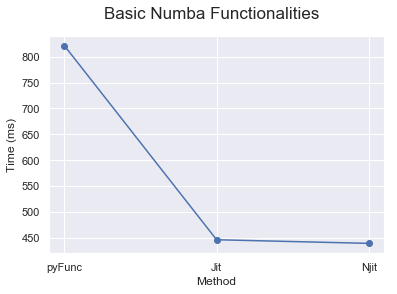

In [4]:
fig, ax = plt.subplots(1, 1)
ax.plot(["a", "b", "c"], [821, 447, 440], "-o") # Results without caching
ax.set_xticklabels(["pyFunc", "Jit", "Njit"])
fig.suptitle("Basic Numba Functionalities", fontsize=17)
ax.set_ylabel("Time (ms)")
ax.set_xlabel("Method")

### `@jit` decorator
Two modes:


## Automatic Multithreading

NumPy array expressions have a significant amount of implied parallelism, as operations are broadcast independently over the input elements.  ParallelAccelerator can identify this parallelism and automatically distribute it over several threads.  All we need to do is enable the parallelization pass with `parallel=True`:

In [14]:
SQRT_2PI = np.sqrt(2 * np.pi)

@jit(nopython=True, parallel=True)
def gaussians(x, means, widths):
    '''Return the value of gaussian kernels.
    
    x - location of evaluation
    means - array of kernel means
    widths - array of kernel widths
    '''
    n = means.shape[0]
    result = np.exp( -0.5 * ((x - means) / widths)**2 ) / widths
    return result / SQRT_2PI / n

means = np.random.uniform(-1, 1, size=1000000)
widths = np.random.uniform(0.1, 0.3, size=1000000)

gaussians(0.4, means, widths)

array([5.44072897e-07, 5.45589108e-07, 2.83017821e-07, ...,
       1.00075293e-06, 3.46886140e-07, 2.98926414e-17])

In [15]:
gaussians_nothread = jit(nopython=True)(gaussians.py_func)

%timeit gaussians_nothread(0.4, means, widths)
%timeit gaussians(0.4, means, widths)

11 ms ± 233 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.25 ms ± 107 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
n = 100000000
a = np.arange(n)
b = 10 * a
a[:10], b[:10], a.dtype, b.dtype

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90]),
 dtype('int32'),
 dtype('int32'))

# SIMD

By using `@vectorize` wrapper you can convert your functions which operates on scalars only, to work for arrays.

| Target   | Description         |
|----------|---------------------|
| cpu      | Single-threaded CPU |
| parallel | Multi-core CPU      |
| cuda     | CUDA GPU            |

In [35]:
n = 10000000
a = np.arange(n)
b = 10 * a
a[:10], b[:10], a.dtype, b.dtype

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90]),
 dtype('int32'),
 dtype('int32'))

In [43]:
def f(x, y):
    return x + y * x

@vectorize(['int32(int32, int32)'], target='cuda')
def f_vec_cuda(x, y):
    return x + y * x

@vectorize(['int32(int32, int32)'], target='parallel')
def f_vec_paral(x, y):
    return x + y * x

@jit(nopython=True)
def f_jit(x, y):
    return x + y * x

@vectorize(['int32(int32, int32)'], target='cpu')
def f_vec_cpu(x, y):
    return x + y * x

@jit(nopython=True, parallel=True)
def f_jit_paral(x, y):
    return x + y * x

#print('a+b:\t', np.add(a, b))
f(a, b)
f_vec_cuda(a, b)
f_vec_paral(a, b)
f_jit(a, b)
f_vec_cpu(a, b)
f_jit_paral(a, b)


print('f_cpu:       ', f_cpu(a, b))
print('f_parallel:  ', f_parallel(a, b))
print('f_vec_cuda:  ', f_cuda(a, b))

f_cpu:        [          0          11          42 ... -2120494889 -1920494938
 -1720494967]
f_parallel:   [          0          11          42 ... -2120494889 -1920494938
 -1720494967]
f_vec_cuda:       [          0          11          42 ... -2120494889 -1920494938
 -1720494967]


In [46]:
numba.cuda.synchronize()

#%timeit np.add(a, b)
%timeit f(a, b)
%timeit f_vec_cuda(a, b)
%timeit f_vec_paral(a, b)
%timeit f_jit(a, b)
%timeit f_vec_cpu(a, b)
%timeit f_jit_paral(a, b)

a_device   = cuda.to_device(a)
b_device   = cuda.to_device(b)
out_device = cuda.device_array(shape=(n), dtype=np.int32)
%timeit f_vec_cuda(a_device, b_device, out=out_device)

37.2 ms ± 125 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
38.3 ms ± 242 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
25.1 ms ± 285 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
16.4 ms ± 348 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
16.2 ms ± 171 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.9 ms ± 123 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
358 µs ± 2.72 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Text(0.5, 0, 'Method')

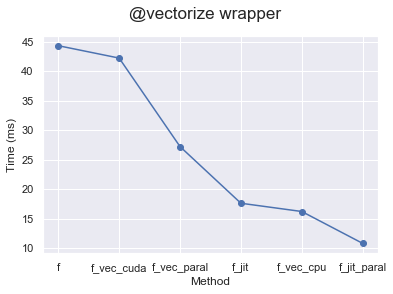

In [45]:
fig, ax = plt.subplots(1, 1)
ax.plot(["a", "b", "c", "d", "e", "f"], [44.3, 42.2, 27.2, 17.6, 16.2, 10.8], "-o")
ax.set_xticklabels(["f", "f_vec_cuda", "f_vec_paral", "f_jit", "f_vec_cpu", "f_jit_paral"])
fig.suptitle("@vectorize wrapper", fontsize=17)
ax.set_ylabel("Time (ms)")
ax.set_xlabel("Method")

# Managing GPU Memory
If you want to reduce the impact of host-to-device/device-to-host bandwidth, it is best to copy data to the GPU explicitly and leave it there to amortize the cost over multiple function calls.

In [50]:
a_device = cuda.to_device(a)
b_device = cuda.to_device(b)

Device arrays can be passed to CUDA functions just like NumPy arrays, but without the copy overhead:

In [51]:
%timeit add4(a_device, b_device)

465 µs ± 2.36 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


That's a big performance improvement already, but we are still allocating a device array for the output of the ufunc and copying it back to the host. We can create the output buffer with the numba.cuda.device_array() function:

In [54]:
out_device = cuda.device_array(shape=(n), dtype=np.int32)  # does not initialize the contents, like np.empty()

And then we can use a special out keyword argument to the ufunc to specify the output buffer:

In [55]:
%timeit add4(a_device, b_device, out=out_device)

374 µs ± 4.46 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Now that we have removed the device allocation and copy steps, the computation runs much faster than before. When we want to bring the device array back to the host memory, we can use the copy_to_host() method:

In [68]:
out_host = out_device.copy_to_host()
print(out_host)

[      0      11      22 ... 1099967 1099978 1099989]


# CUDA
Create kernel. You will have to pass two things:
- Number of threads per block,
- Number of blocks.

In [8]:
numba.cuda.is_available()

True

In [9]:
numba.cuda.detect()

Found 1 CUDA devices
id 0    b'GeForce GTX 1080 Ti'                              [SUPPORTED]
                      compute capability: 6.1
                           pci device id: 0
                              pci bus id: 1
Summary:
	1/1 devices are supported


True

In [50]:
numba.cuda.grid()

TypeError: 'Macro' object is not callable

In [29]:
n = 100000
x = np.arange(n).astype(np.float32)
y = 2 * x
out = np.empty_like(x)

threads_per_block = 128
blocks_per_grid   = 30

add_kernel[blocks_per_grid, threads_per_block](x, y, out)
print(out[:10])

[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27.]
